In [5]:
# INSTALL REQUIRED LIBRARIES
!pip install pandas boto3 scikit-learn matplotlib seaborn wordcloud xgboost --quiet


In [6]:
# === IMPORTS ===
import pandas as pd
import boto3
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [7]:
# === LOAD DATA FROM S3 ===
bucket = 'youtube-trending-cleaned-v2'  # <-- replace with your actual bucket name
original_key = 'US_youtube_trending_data.csv'
preprocessed_key = 'Pre_Processed_US_YouTube_Trending_Videos.csv'

s3 = boto3.client('s3')

original_df = pd.read_csv(s3.get_object(Bucket=bucket, Key=original_key)['Body'])
preprocessed_df = pd.read_csv(s3.get_object(Bucket=bucket, Key=preprocessed_key)['Body'])


In [8]:
# === DATA INSPECTION ===
print("\n===== Dataset Size Comparison =====")
print(f"Original Dataset Rows: {len(original_df)}")
print(f"Preprocessed Dataset Rows: {len(preprocessed_df)}")

missing_original = original_df.isnull().sum().sum()
missing_preprocessed = preprocessed_df.isnull().sum().sum()
print("\n===== Missing Values Comparison =====")
print(f"Missing in Original: {missing_original}")
print(f"Missing in Preprocessed: {missing_preprocessed}")

unique_original = original_df['video_id'].nunique()
unique_preprocessed = preprocessed_df['video_id'].nunique()
print("\n===== Unique Videos Comparison =====")
print(f"Unique videos in Original: {unique_original}")
print(f"Unique videos in Preprocessed: {unique_preprocessed}")



===== Dataset Size Comparison =====
Original Dataset Rows: 268787
Preprocessed Dataset Rows: 45043

===== Missing Values Comparison =====
Missing in Original: 4549
Missing in Preprocessed: 936

===== Unique Videos Comparison =====
Unique videos in Original: 47142
Unique videos in Preprocessed: 7901


/tmp/ipykernel_17132/1191481593.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Original', 'Preprocessed'], y=[len(original_df), len(preprocessed_df)], palette='Blues')


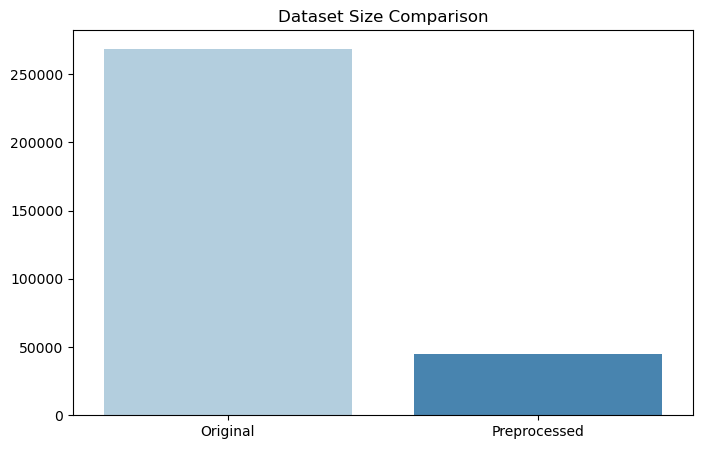

/tmp/ipykernel_17132/1191481593.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Original', 'Preprocessed'], y=[missing_original, missing_preprocessed], palette='Reds')


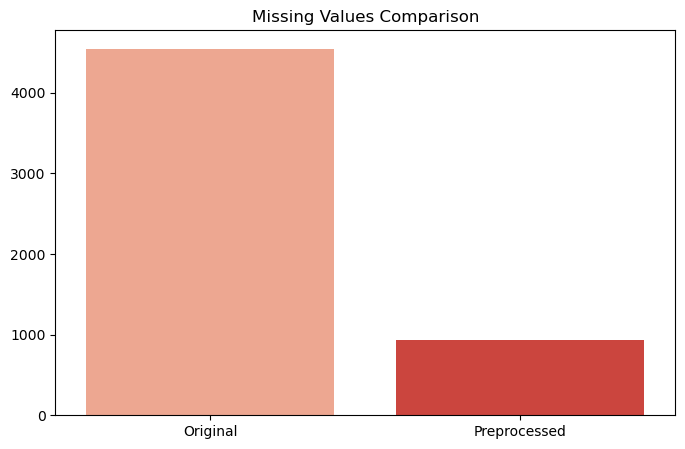

/tmp/ipykernel_17132/1191481593.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Original', 'Preprocessed'], y=[unique_original, unique_preprocessed], palette='Greens')


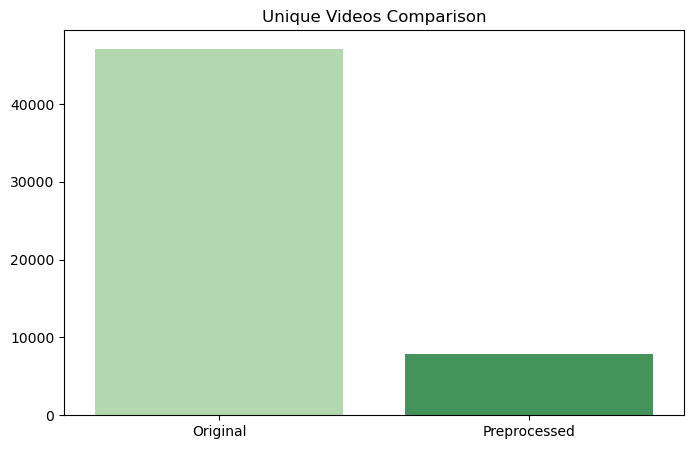

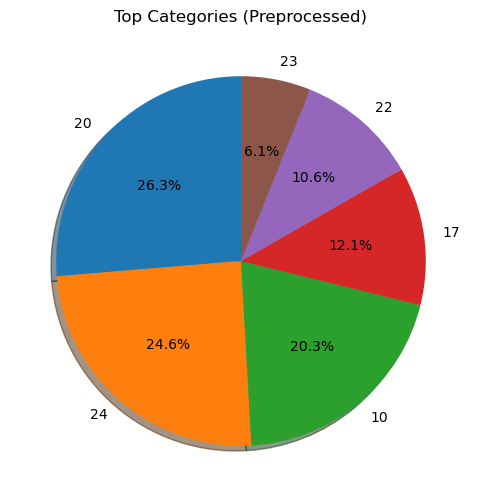

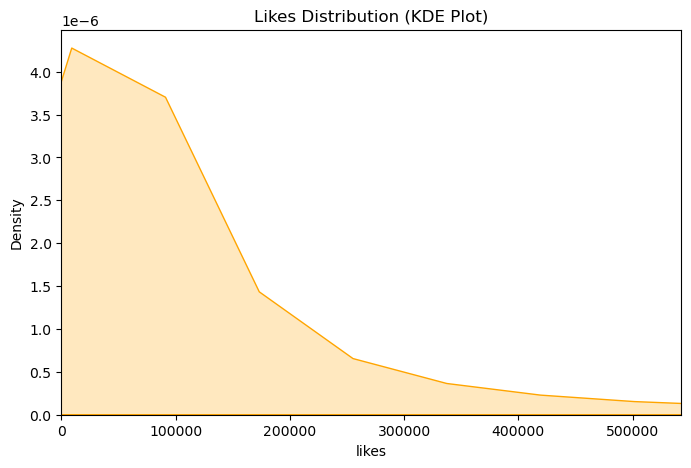

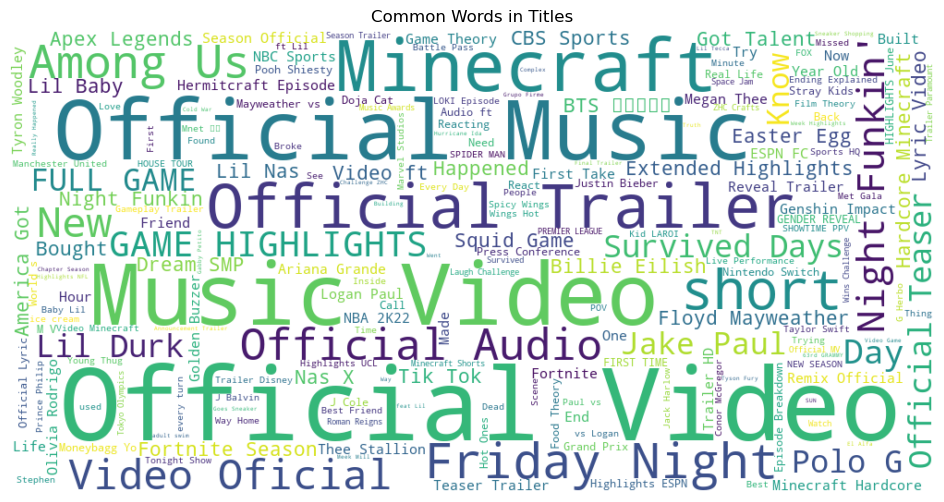

In [9]:
# === VISUALIZATIONS ===
plt.figure(figsize=(8,5))
sns.barplot(x=['Original', 'Preprocessed'], y=[len(original_df), len(preprocessed_df)], palette='Blues')
plt.title('Dataset Size Comparison')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=['Original', 'Preprocessed'], y=[missing_original, missing_preprocessed], palette='Reds')
plt.title('Missing Values Comparison')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=['Original', 'Preprocessed'], y=[unique_original, unique_preprocessed], palette='Greens')
plt.title('Unique Videos Comparison')
plt.show()

plt.figure(figsize=(6,6))
preprocessed_df['categoryId'].value_counts().head(6).plot.pie(autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Top Categories (Preprocessed)')
plt.ylabel('')
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(data=preprocessed_df, x='likes', fill=True, color='orange')
plt.title('Likes Distribution (KDE Plot)')
plt.xlim(0, preprocessed_df['likes'].quantile(0.95))
plt.show()

title_text = ' '.join(preprocessed_df['title'].dropna().tolist())
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(title_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Titles')
plt.show()

In [6]:
import boto3
import pandas as pd

s3 = boto3.client('s3')
bucket = 'youtube-trending-cleaned-v2'
preprocessed_key = 'Pre_Processed_US_YouTube_Trending_Videos.csv'

response = s3.get_object(Bucket=bucket, Key=preprocessed_key)
preprocessed_df = pd.read_csv(response['Body'])


In [7]:
# PREPROCESSING (if not already done)
data = preprocessed_df.copy()
data = data.drop(['video_id', 'publishedAt', 'thumbnail_link', 'channelId'], axis=1)
data['description'] = data['description'].fillna('')
data['is_trending'] = (data['view_count'] > data['view_count'].median()).astype(int)
data = pd.get_dummies(data, columns=['channelTitle'], drop_first=True)
data = data.drop(['tags', 'title', 'description', 'trending_date'], axis=1)

# SPLITTING
X = data.drop('is_trending', axis=1)
y = data['is_trending']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# IMPORT
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# TRAIN NAIVE BAYES
nb = MultinomialNB()
nb.fit(X_train, y_train)

# PREDICT
y_pred_nb = nb.predict(X_test)

# EVALUATE
print("\nNaive Bayes Evaluation:")
print(classification_report(y_test, y_pred_nb))

# METRICS
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb)
nb_recall = recall_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb)

print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall: {nb_recall:.4f}")
print(f"F1 Score: {nb_f1:.4f}")



Naive Bayes Evaluation:
              precision    recall  f1-score   support

           0       0.53      0.48      0.50      4428
           1       0.54      0.60      0.57      4581

    accuracy                           0.54      9009
   macro avg       0.54      0.54      0.54      9009
weighted avg       0.54      0.54      0.54      9009

Accuracy: 0.5376
Precision: 0.5411
Recall: 0.5962
F1 Score: 0.5673


In [12]:
# Fix column names for X_train and X_test if using text vectorization
X_train.columns = [f'feature_{i}' for i in range(X_train.shape[1])]
X_test.columns = X_train.columns  # Match column names exactly


In [13]:
# IMPORT
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# TRAIN XGBOOST
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# PREDICT
y_pred_xgb = xgb.predict(X_test)

# EVALUATE
print("\nXGBoost Evaluation:")
print(classification_report(y_test, y_pred_xgb))

# METRICS
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [02:41:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4428
           1       1.00      1.00      1.00      4581

    accuracy                           1.00      9009
   macro avg       1.00      1.00      1.00      9009
weighted avg       1.00      1.00      1.00      9009

Accuracy: 0.9976
Precision: 0.9972
Recall: 0.9980
F1 Score: 0.9976
